In [2]:
import drawsvg as dw
from os import listdir
dir = '/home/jh/src/svg/lib'
files = listdir(dir)
for file in files:
    if file[-3:] == '.py':
        f = '%s/%s' % (dir,file)
        exec(open(f).read())

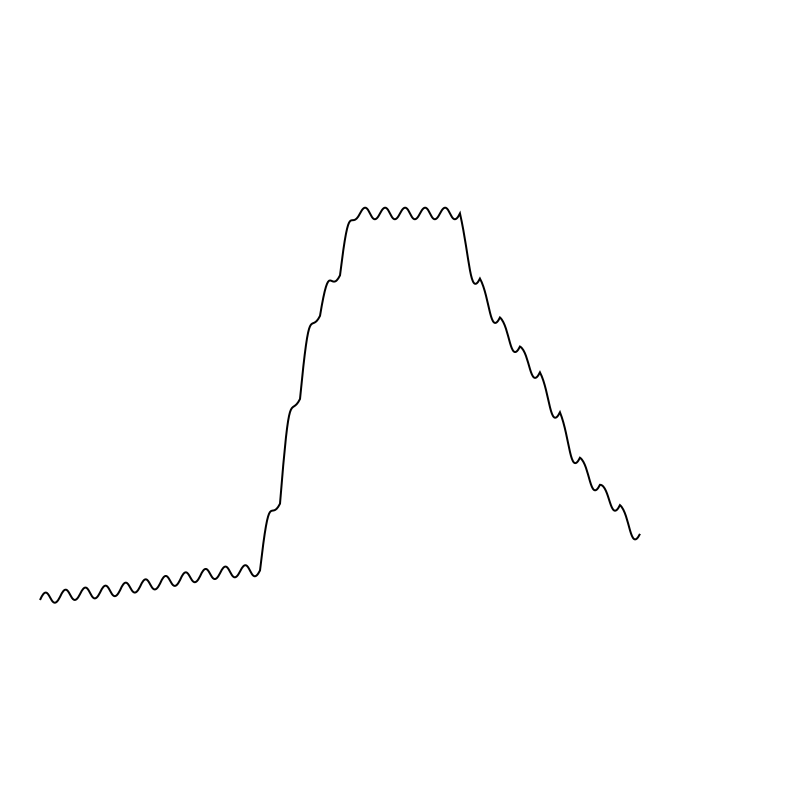

In [14]:
d = dw.Drawing(200,200)

def varVibr2_lseg(xyseg=[10,10,50,100,150,50],hmin=5,hmax=10,prdmin=3,prdmax=9,
               hmaxdiffac=1,prdmaxdiffac=1,mdiffac=2,c='black',sw=1,returnonly=0,**args):
    """wie varVibr2_l aber als xy segmente in xylis
    mit hmaxdiffac und prdmaxdiffac lässt sich die maximale abweichung von einem
    zum nächsten schritt steuern
    mdiffac=2 bedeutet dass die steigung in einer periode zwischen m/2 und m*2 liegt
    gibt den pfad zurück
    wenn returnonly=1 wird NUR der pfad zurückgegeben"""
    from random import uniform
    hmaxdiff = (hmax-hmin) * hmaxdiffac #maximale veränderung zwischen zwei perioden
    prdmaxdiff = (prdmax-prdmin) * prdmaxdiffac #dito
    numseg = len(xyseg) // 2
    # die x und y werte in eigene listen schreiben
    xseg = [xyseg[i*2] for i in range(numseg)]
    yseg = [xyseg[i*2+1] for i in range(numseg)]
    # anfangswerte setzen
    m = (yseg[1]-yseg[0]) / (xseg[1]-xseg[0])
    m_maxdiff = ((m*mdiffac)-(m/mdiffac)) / 2
    x,y = xseg[0],yseg[0]
    h = (hmin+hmax) / 2 
    prd = (prdmin+prdmax) / 2 
    mhier = m
    indx = 0
    # der pfad
    p = dw.Path(fill='none',stroke=c,stroke_width=sw,**args)
    p.M(x,y)
    # iterieren
    while x < xseg[-1]:
        mhier = brownian1(mhier,m/mdiffac,m*mdiffac,m_maxdiff)
        xtarget = x+prd
        h = brownian1(h,hmin,hmax,hmaxdiff)
        ytarget = y+(xtarget-x)*mhier
        c1 = x+prd/2,ytarget-h
        c2 = x+prd/2,ytarget+h
        p.C(*c1,*c2,xtarget,ytarget)
        x = xtarget
        y = ytarget
        prd = brownian1(prd,prdmin,prdmax,prdmaxdiff)
        # ggf index raufsetzen und steigung aktualisieren 
        if x > xseg[indx+1] and indx < len(xseg)-2:
            indx += 1
            m = (yseg[indx+1]-yseg[indx]) / (xseg[indx+1]-xseg[indx])
            m_maxdiff = ((m*mdiffac)-(m/mdiffac)) / 2
            mhier = m
    if returnonly==0: d.append(p)
    return p

#varVibr2_lseg()
y = 150
y1 = 50
x = 10
xunit = 25
varVibr2_lseg([x,y,x+xunit*2,y-5,x+xunit*3,y1,x+xunit*4,y1,x+xunit*6,y],hmin=5,hmax=5,prdmin=5,prdmax=5,sw=.5)

d.set_pixel_scale(4)
#d.save_png('varVib.png')
#d.save_svg('varVib.svg')
d